# Project4 - Group11

## Algorithm implementation and evaluation 

In this project we will measure and compare different methods for factorized rating models in recommender system. We will compare the models in two metrics: running cost (training and inference cost) and recommendation accuracy (i.e., how accurate is our guess of costumers' rating to certain movies).

### 1. Load data and data preprocessing 

In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import timeit
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/ml-latest-small/ratings.csv')

In [3]:
#training & test split by 0.8 & 0.2 randomly
train, test = train_test_split(data, test_size = 0.2)

### 2. Algorithm implementation with regularization 

#### 2.1 Basic model
#### A1+R1+R2

In [4]:
def sgd_bias(data, train, f = 10, lam = 0.3, lrate = 0.01, epoch = 10, stopping_deriv = 0.01):

    #define the length of unique userid and movieid 
    U = len(data['userId'].unique())
    I = len(data['movieId'].unique())
    
    p = np.random.randn(f, U)
    q = np.random.randn(f, I)
    
    tmp1 = [i for i in range(I)]
    tmp2 = data['movieId'].unique()
    movie_dic = dict(zip(tmp2,tmp1))
    
    train_data = np.array(train)
    
    user_mean = data.groupby('userId').mean()['rating']
    user_mean = np.array(user_mean)
    
    item_mean = data.groupby('movieId').mean()['rating']
    tmp_item_index = item_mean.index.tolist()
    tmp_movie_dic = dict(zip(tmp_item_index, [i for i in range(I)]))
    item_mean = np.array(item_mean)
    
    total_mean = np.mean(data['rating'])
    user_bias = user_mean - total_mean
    item_bias = item_mean - total_mean
    
    sample_index = [index for index in range(train_data.shape[0])]
    
    #for n epochs
    for e in range(epoch):
        
        #random initialization
        random.shuffle(sample_index)
        
        #training matrix p and q
        for index in sample_index:
            u = int(train_data[index,0])
            i = int(train_data[index,1])
            r_ui = train_data[index,2]
            bias_u = user_bias[u-1]
            bias_i = item_bias[tmp_movie_dic[i]]
            e_ui = r_ui - total_mean - bias_u - bias_i - np.dot(q[:,movie_dic[i]].T, p[:,u-1])
            
            grad_user = e_ui * p[:,u-1] - lam * q[:, movie_dic[i]]
            if(all(np.abs(grad)) > stopping_deriv for grad in grad_user):
                q[:,movie_dic[i]] = q[:,movie_dic[i]] + lrate * grad_user
                
            grad_item = e_ui * q[:,movie_dic[i]] - lam* p[:,u-1]
            if(all(np.abs(grad)) > stopping_deriv for grad in grad_item):
                p[:,u-1] = p[:,u-1] + lrate * grad_item
                
            grad_user_bias = e_ui - lam * bias_u
            if (np.abs(grad_user_bias) > stopping_deriv):
                user_bias[u-1] = bias_u + lrate * grad_user_bias
            
            grad_item_bias = e_ui - lam * bias_i
            if (np.abs(grad_item_bias) > stopping_deriv):
                item_bias[tmp_movie_dic[i]] = bias_i + lrate * grad_item_bias 
    
    #calculate rating matrix
    r_ij = total_mean + user_bias + np.dot(q.T,p)
    r_ij = (r_ij.T + item_bias).T
    return p,q, r_ij

#### 2.2 Cross-Validation for parameter tuning

In [6]:
# function of computing RMSE
def RMSE(rating, est_rating):
    sqr_error = []
    for r in range(rating.shape[0]):
        u = int(rating[r,0])
        i = int(rating[r,1])
        r_ui = rating[r,2]
        est_r_ui = est_rating.at[i, u]
        sqr_error.append((r_ui - est_r_ui) ** 2)
    return np.sqrt(np.mean(sqr_error))      

In [7]:
def get_fold(data,K):
    fold_num = []
    i =0
    while i<len(data):
        for j in range(5):
            if(i<len(data)):
                fold_num.append(j)
            i+=1
    return fold_num

In [8]:
# function of conducting cross-validation
def cv(tr, K, f, lambda_):
    df = tr
    df['fold'] = get_fold(tr,K)
    test_errors = []
    train_errors = []
    for k in range(K):
        #print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        
        train_error, test_error=predict(k_train,k_test,f,lambda_)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [9]:
# function of computing training RMSE and test RMSE  
def predict(train_data, test_data,f,lambda_):
        
        train_RMSE = []
        test_RMSE = []
        p,q,r_ij = sgd_bias(data, train_data,f,lambda_)
        est_rating = pd.DataFrame(r_ij)
        est_rating.index = data['movieId'].unique().tolist()
        est_rating.columns = data['userId'].unique().tolist()
        est_rating = pd.DataFrame(est_rating)
        train_data = np.array(train_data)
        test_data = np.array(test_data)

        train_RMSE_cur = RMSE(train_data, est_rating)
        train_RMSE.append(train_RMSE_cur)
        #print("training RMSE:", train_RMSE_cur)
        test_RMSE_cur = RMSE(test_data, est_rating)
        test_RMSE.append(test_RMSE_cur)
        #print("test RMSE:", test_RMSE_cur)

        return [train_RMSE, test_RMSE]

In [66]:
# Parameter tuning of f and lambda
f_s = np.array([1,2,5,10]).astype(int)
lambda_s= np.array([0.1,0.5,1,5]).astype(int)

#train for 10 iterarions each time
trains = []
tests = []
for f in f_s:
    train_avs = []
    test_avs = []
    for lambda_ in lambda_s:
        tr_rmse,tst_rmse=cv(data, 5, f, lambda_)
        
        train_avs.append(np.mean(tr_rmse))
        test_avs.append(np.mean(tst_rmse))
    trains.append(train_avs)
    tests.append(test_avs)
#print(trains)
#print(tests)

In [127]:
#save the output
#trains_basic=pd.DataFrame(trains)
#tests_basic=pd.DataFrame(tests)
#trains_basic.to_csv("../output/trains.csv")
#tests_basic.to_csv("../output/tests.csv")

#### 2.3 Plot RMSE for basic model

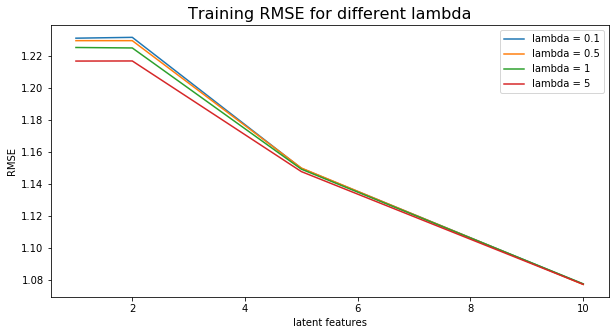

In [67]:
plt.figure(figsize=(10,5))
plt.plot(f_s,trains[0])
plt.plot(f_s,trains[1])
plt.plot(f_s,trains[2])
plt.plot(f_s,trains[3])

plt.legend(['lambda = 0.1', 'lambda = 0.5', 'lambda = 1',
           'lambda = 5'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Training RMSE for different lambda", fontsize=16)

plt.show()

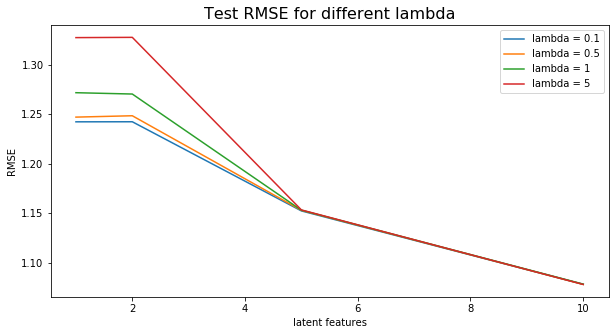

In [68]:
plt.figure(figsize=(10,5))
plt.plot(f_s,tests[0])
plt.plot(f_s,tests[1])
plt.plot(f_s,tests[2])
plt.plot(f_s,tests[3])
plt.legend(['lambda = 0.1', 'lambda = 0.5', 'lambda = 1', 'lambda = 5'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Test RMSE for different lambda", fontsize=16)

plt.show()

From the plot we can see that the larger the f we choose, the better the performance of factorization is. While when f=10, training RMSE and test RMSE do not have distinct difference varing from different lambdas. So we set f=10 and try many different lambda to choose the best parameter.

In [ ]:
lambda_list = [0.01, 0.1, 0.3, 0.5, 1, 3, 5]

trains_la = []
tests_la = []
for l in lambda_list:
    train_la,test_la = cv(data,5,10,l)
    trains_la.append(np.mean(train_la))
    tests_la.append(np.mean(test_la))

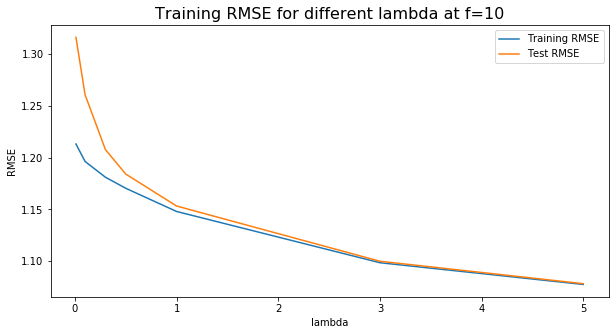

In [126]:
plt.figure(figsize=(10,5))
plt.plot(lambda_list,trains_la)
plt.plot(lambda_list,tests_la)
plt.legend(['Training RMSE', 'Test RMSE'], loc='upper right')
plt.xlabel('lambda', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Training RMSE for different lambda at f=10", fontsize=16)

plt.show()

 According to the diagram above, we choose `f=10,lambda=5`.

### 3. Postprocessing - KNN 

#### 3.1 Optimization model
#### A1+R1+R2+P2

In [10]:
def knn(p,q,r_ij, k=1,test_point=None):
    U = len(test_point['userId'].unique())
    I = len(test_point['movieId'].unique())
    
    sim = pairwise_distances(q.T,metric='cosine')
    sim = pd.DataFrame(sim)
    knn_r_ij = []
    tmp = list(test_point['movieId'].unique())
    
    tmp1 = [i for i in range(I)]
    tmp2 = test_point['movieId'].unique()
    movie_dic = dict(zip(tmp2,tmp1))
    
    for i in tmp:
        k_neighbors_class = np.argsort(sim[movie_dic[i]])[1:1+k]
        knn_r_ij.append(np.mean(r_ij[k_neighbors_class,:],axis=0))
    knn_r_ij = pd.DataFrame(knn_r_ij)
    knn_r_ij.index = test_point['movieId'].unique().tolist()
    knn_r_ij.columns = test_point['userId'].unique().tolist()
    
    return knn_r_ij

#### 3.2 Cross-Validation for parameter tuning

In [11]:
#set f=10, lambda=5
p_1,q_1,r_ij_1 = sgd_bias(data, train, 10,5)

In [12]:
def predict_knn(train_data, test_data,kk):

    train_RMSE = []
    test_RMSE = []
    knn_r_ij = knn(p_1,q_1,r_ij_1,kk,test_point = data)
    est_rating = pd.DataFrame(knn_r_ij)
    est_rating.index = data['movieId'].unique().tolist()
    est_rating.columns = data['userId'].unique().tolist()
    est_rating = pd.DataFrame(est_rating)
    train_data = np.array(train_data)
    test_data = np.array(test_data)

    train_RMSE_cur = RMSE(train_data, est_rating)
    train_RMSE.append(train_RMSE_cur)
    #print("training RMSE:", train_RMSE_cur)
    test_RMSE_cur = RMSE(test_data, est_rating)
    test_RMSE.append(test_RMSE_cur)
    #print("test RMSE:", test_RMSE_cur)

    return [train_RMSE, test_RMSE]

In [13]:
def cv_knn(tr, K, KK):
    df = tr
    df['fold'] = get_fold(tr,K)
    test_errors = []
    train_errors = []
    for k in range(K):
        #print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        
        train_error, test_error=predict_knn(k_train,k_test,KK)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [99]:
#train for 10 iterarions each time
trains_knn = []
tests_knn = []
for KK in range(1,11):
        train_knn,test_knn = cv_knn(data,5,KK)
        trains_knn.append(np.mean(train_knn))
        tests_knn.append(np.mean(test_knn))

print("Training RMSE: ", trains_knn)  
print("Test RMSE: ", tests_knn)

Training RMSE:  [1.12954637373708, 1.0871838844872193, 1.0713041389484754, 1.059163097131394, 1.050578561375458, 1.0444557767091442, 1.0408118533012138, 1.0386042152303487, 1.0362311279367307, 1.0349538769657012]
Test RMSE:  [1.1295371583973737, 1.0871700470016379, 1.0712943749915316, 1.0591531984602323, 1.0505642899046013, 1.0444419253979924, 1.0407989375207451, 1.0385916054123778, 1.036217062157601, 1.034940464894277]


#### 3.3 Plot RMSE for optimization model 

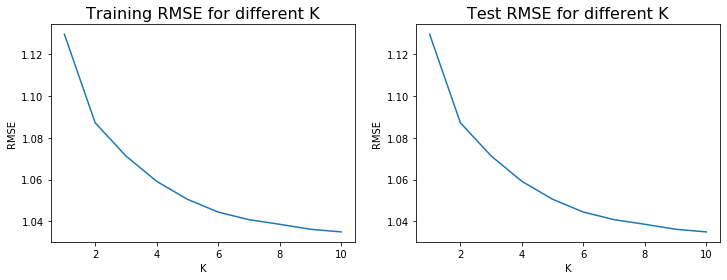

In [111]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(range(1,11),trains_knn)
ax[1].plot(range(1,11),tests_knn)
#plt.legend(["Training MSE of KNN","Test MSE of KNN"], loc='upper right')
ax[0].set_xlabel('K', fontsize=10)
ax[0].set_ylabel('RMSE', fontsize=10)
ax[0].set_title("Training RMSE for different K", fontsize=16)
ax[1].set_xlabel('K', fontsize=10)
ax[1].set_ylabel('RMSE', fontsize=10)
ax[1].set_title("Test RMSE for different K", fontsize=16)
plt.show()

 We choose `K=10`   
 According to the results above, we choose `f=10, lambda=5, K=10`

### 4. Postprocessing - Kernel Ridge Regression 

#### 4.1 Optimization model
#### A1+R1+R2+P3

In [14]:
def krr(q,data,train,alpha,kernel):
    import numpy as np
    import pandas as pd
    
    from sklearn import preprocessing
    from sklearn.kernel_ridge import KernelRidge  
    
    n_movies=np.unique(data.movieId).shape[0]
    n_users=np.unique(data.userId).shape[0]

    updated_rating_mat=np.zeros((n_users,n_movies))
    
    q=q.T
    
    #normalize q matrix
    q_normalize=preprocessing.normalize(q) #mat_q:
    q_normalize.shape
    q_normalize=pd.DataFrame(q_normalize.T)
    q_normalize.columns=[np.unique(data.movieId)]
    
       
    for i in range(n_users):
        
        rating_i=train.loc[train['userId']==i+1,['movieId','rating']]
        movieId_i=rating_i.iloc[:,0]
        y_i=rating_i.iloc[:,1]#rating vector of user i
           
        #create X for user i
        X_i=q_normalize.loc[:,movieId_i]
        
        #predictions of krr
        krr = KernelRidge(alpha,kernel)
        krr.fit(X_i.T,y_i)

        pred_krr=krr.predict(q_normalize.T)            
        updated_rating_mat[i]=pred_krr          
        
    return(updated_rating_mat)


#### 4.2 Cross-Validation for parameter tuning

In [15]:
def predict_krr(train_data, test_data,alpha,kernel):

    train_RMSE = []
    test_RMSE = []
    krr_r_ij = krr(q_1,data,train,alpha,kernel)
    est_rating = pd.DataFrame(krr_r_ij)
    est_rating = est_rating.transpose()
    est_rating.index = data['movieId'].unique().tolist()
    est_rating.columns = data['userId'].unique().tolist()
    train_data = np.array(train_data)
    test_data = np.array(test_data)

    train_RMSE_cur = RMSE(train_data, est_rating)
    train_RMSE.append(train_RMSE_cur)
    #print("training RMSE:", train_RMSE_cur)
    test_RMSE_cur = RMSE(test_data, est_rating)
    test_RMSE.append(test_RMSE_cur)
    #print("test RMSE:", test_RMSE_cur)

    return [train_RMSE, test_RMSE]

In [16]:
def cv_krr(tr, K, alpha,kernel):
    df = tr
    df['fold'] = get_fold(tr,K)
    test_errors = []
    train_errors = []
    for k in range(K):
        #print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        
        train_error, test_error=predict_krr(k_train,k_test,alpha,kernel)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [ ]:
# Parameter tuning of alpha and kernel
alpha_s = np.array([0.1,0.5,1,2,5,10,20]).astype(int)
kernel_s= np.array(["linear","rbf"]).astype(str)

#train for 10 iterarions each time
trains_krr = []
tests_krr = []
for kernel in kernel_s:
    train_avs_krr = []
    test_avs_krr = []
    for alpha in alpha_s:
        tr_rmse_krr,tst_rmse_krr=cv_krr(data, 5, alpha, kernel)
        
        train_avs_krr.append(np.mean(tr_rmse_krr))
        test_avs_krr.append(np.mean(tst_rmse_krr))
    trains_krr.append(train_avs_krr)
    tests_krr.append(test_avs_krr)
    
#print(trains_krr)
#print(tests_krr)

In [133]:
print("Training RMSE: ", trains_krr)  
print("Test RMSE: ", tests_krr)

Training RMSE:  [[3.90058228 3.90058228 3.7303341  3.70714682 3.6795031  3.66390898
  3.65417143]
 [1.73401904 1.73401904 0.95014282 0.95002658 0.97183366 1.03054549
  1.15960631]]
Test RMSE:  [[3.9005385  3.9005385  3.73032434 3.7071401  3.67949944 3.66390668
  3.65416987]
 [1.73396519 1.73396519 0.95012499 0.9500084  0.97181545 1.03052793
  1.15959081]]


In [135]:
#save the output
#trains_krr=pd.DataFrame(trains_krr)
#tests_krr=pd.DataFrame(tests_krr)
#trains_krr.to_csv("../output/trains_krr.csv")
#tests_krr.to_csv("../output/tests_krr.csv")

#### 4.3 Plot RMSE for optimization model

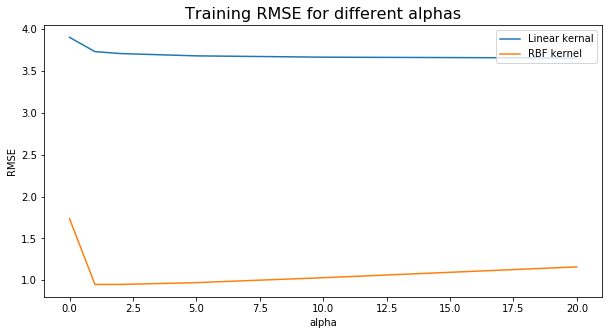

In [120]:
plt.figure(figsize=(10,5))
plt.plot(alpha_s,trains_krr[0])
plt.plot(alpha_s,trains_krr[1])

plt.legend(['Linear kernal', 'RBF kernel'], loc='upper right')
plt.xlabel('alpha', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Training RMSE for different alphas", fontsize=16)

plt.show()

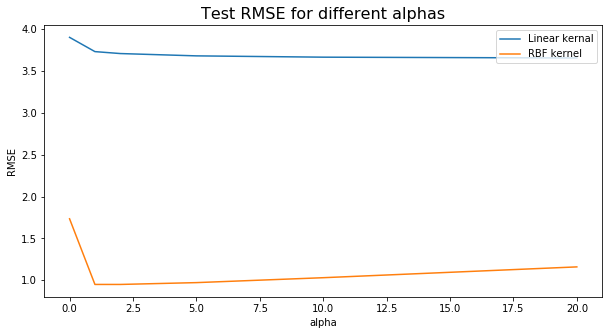

In [121]:
plt.figure(figsize=(10,5))
plt.plot(alpha_s,tests_krr[0])
plt.plot(alpha_s,tests_krr[1])

plt.legend(['Linear kernal', 'RBF kernel'], loc='upper right')
plt.xlabel('alpha', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Test RMSE for different alphas", fontsize=16)

plt.show()

According to the results above, we choose `f=10,lambda=5,alpha=1,kernel="rbf"`.

### 5. Evaluation 

Now we evaluate and compare between two different post-processing methods after we measured the performance of the basic algorithm.

In [25]:
start1 = timeit.default_timer()
trmse1, temse1 = predict(train, test,10,5)
stop1 = timeit.default_timer()
           
print('Running Time for SGD+R1+R2: ', stop1 - start1, 's')

print('Training MSE of SGD+R1+R2 is ', trmse1, ', and test mse of P2 is ', temse1)

Running Time for SGD+R1+R2:  27.82926520000001 s
Training MSE of SGD+R1+R2 is  [1.0773972429958685] , and test mse of P2 is  [1.0791488079583413]


In [21]:
start3 = timeit.default_timer()
trmse3, temse3 = predict_krr(train, test, 1, "rbf")
stop3 = timeit.default_timer()

In [22]:
start2 = timeit.default_timer()
trmse2, temse2 = predict_knn(train, test, 10)
stop2 = timeit.default_timer()

In [23]:
print('Running Time for Post-processing P2: ', stop2 - start2, 's')
print('Running Time for Post-processing P3: ', stop3 - start3, 's')

print('Training MSE of P2 is ', trmse2, ', and test mse of P2 is ', temse2)
print('Training MSE of P3 is ', trmse3, ', and test mse of P3 is ', temse3)


Running Time for Post-processing P2:  18.27819850000003 s
Running Time for Post-processing P3:  36.89328619999998 s
Training MSE of P2 is  [1.0266159152107408] , and test mse of P2 is  [1.0308111278683425]
Training MSE of P3 is  [0.9473794401609528] , and test mse of P3 is  [0.9594510041475915]


In colusion, we see that there is a trade-off between running cost (i.e., time spent) and accuracy for post-processing algorithms.